In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mpe 
from scipy.stats import pearsonr as pearson

In [ ]:
df = pd.read_csv('pm_10.csv',parse_dates = True, index_col =0)

In [2]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df.isna().sum()

In [ ]:
df.drop('station',axis = 1,inplace = True)

In [ ]:
imputer = KNNImputer(n_neighbors = 2)
X = imputer.fit_transform(df)
df = pd.DataFrame(X,columns = df.columns,index = df.index)

In [ ]:
df.isna().sum()

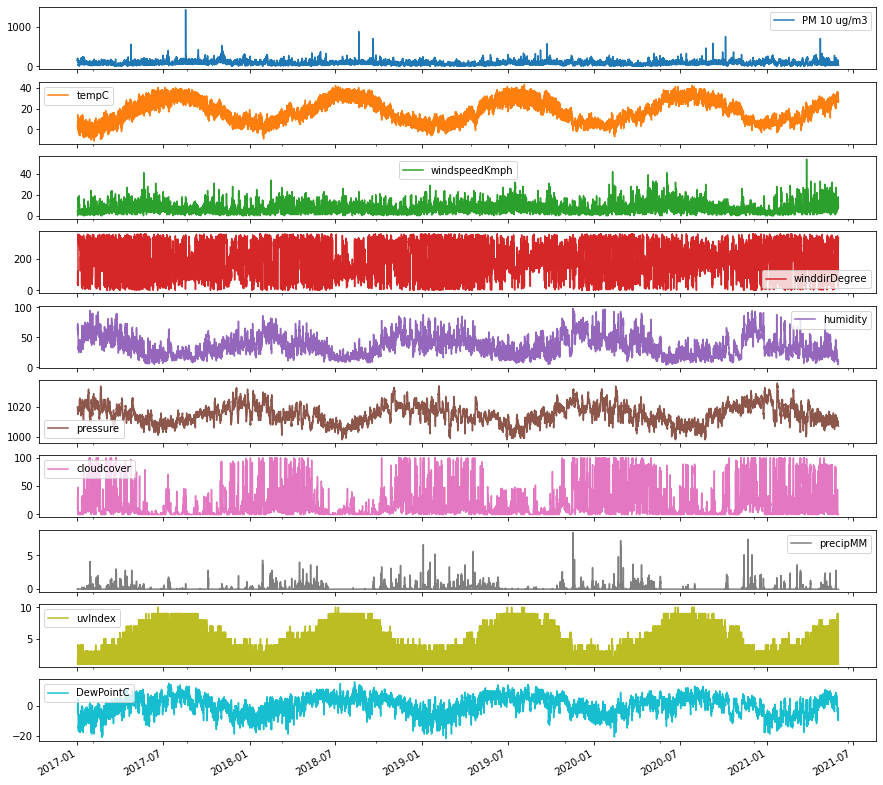

In [8]:
df.plot(subplots = True,figsize=(15,15))
plt.show()

In [9]:
df

,PM 10 ug/m3,tempC,windspeedKmph,winddirDegree,humidity,pressure,cloudcover,precipMM,uvIndex,DewPointC
2017-01-01 00:00:00,159.0,3.0,5.0,49.0,62.0,1020.0,10.0,0.0,1.0,-4.0
2017-01-01 01:00:00,210.0,3.0,4.0,47.0,64.0,1019.0,13.0,0.0,1.0,-3.0
2017-01-01 02:00:00,197.0,3.0,4.0,45.0,65.0,1019.0,16.0,0.0,1.0,-3.0
2017-01-01 03:00:00,179.0,3.0,3.0,43.0,67.0,1018.0,19.0,0.0,1.0,-3.0
2017-01-01 04:00:00,144.0,3.0,3.0,46.0,69.0,1018.0,23.0,0.0,1.0,-3.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 19:00:00,43.0,29.0,11.0,301.0,7.0,1007.0,0.0,0.0,1.0,-7.0
2021-05-31 20:00:00,32.0,28.0,9.0,318.0,7.0,1007.0,0.0,0.0,1.0,-7.0
2021-05-31 21:00:00,29.0,26.0,8.0,334.0,8.0,1007.0,0.0,0.0,1.0,-6.0
2021-05-31 22:00:00,45.0,27.0,8.0,335.0,9.0,1007.0,0.0,0.0,1.0,-5.0


# base line models

## random forest

In [10]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
Y = X[:,0]
X = X[:,1:]

scaler_col = MinMaxScaler()
col = scaler_col.fit_transform(df['PM 10 ug/m3'].to_numpy().reshape(-1,1))

In [11]:
print(f'X: {X.shape} , Y: {Y.shape}')

X: (38687, 9) , Y: (38687,)


In [37]:
from sklearn.ensemble import RandomForestRegressor
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, shuffle = False)
regr = RandomForestRegressor(n_estimators = 200 ,max_depth=30, random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200, random_state=0)

In [38]:
prediction = regr.predict(x_test).reshape(-1,1)
pred_train = regr.predict(x_train)

rev_pred = scaler_col.inverse_transform(prediction)
rev_test = scaler_col.inverse_transform(y_test.reshape(-1,1))

rev_train_pred = scaler_col.inverse_transform(pred_train.reshape(-1,1))
rev_train = scaler_col.inverse_transform(y_train.reshape(-1,1))

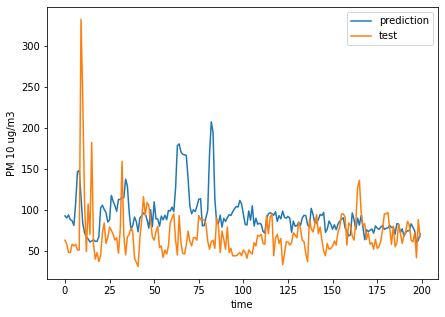

In [24]:
ns=200
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(rev_pred[:ns],label = 'prediction')
ax.plot(rev_test[:ns], label = 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('PM 10 ug/m3')
plt.savefig('forest.pdf',bbox_inches='tight')
plt.show()

In [25]:
print(f'correlation on test: {pearson(rev_test.flatten(),rev_pred.flatten())[0]} \ncorrelation on train: {pearson(rev_train.flatten(),rev_train_pred.flatten())[0]}')

correlation on test: 0.338086223355868 
correlation on train: 0.9769336101882377


In [40]:
mse(rev_test.flatten(),rev_pred.flatten())

1719.3577317864585

## KNN regressor

In [27]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [33]:
prediction = neigh.predict(x_test).reshape(-1,1)
pred_train = neigh.predict(x_train)

rev_pred = scaler_col.inverse_transform(prediction)
rev_test = scaler_col.inverse_transform(y_test.reshape(-1,1))

rev_train_pred = scaler_col.inverse_transform(pred_train.reshape(-1,1))
rev_train = scaler_col.inverse_transform(y_train.reshape(-1,1))

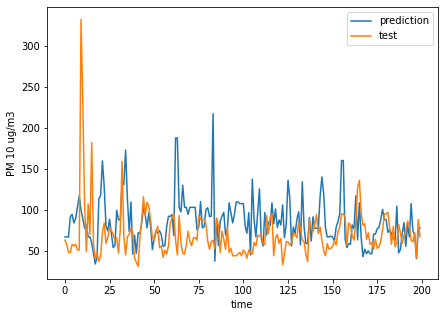

In [34]:
ns=200
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(rev_pred[:ns],label = 'prediction')
ax.plot(rev_test[:ns], label = 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('PM 10 ug/m3')
plt.savefig('knn.pdf',bbox_inches='tight')
plt.show()

In [35]:
print(f'correlation on test: {pearson(rev_test.flatten(),rev_pred.flatten())[0]} \ncorrelation on train: {pearson(rev_train.flatten(),rev_train_pred.flatten())[0]}')

correlation on test: 0.22982295248721332 
correlation on train: 0.9019952883189783


In [36]:
mse(rev_test.flatten(),rev_pred.flatten())

2536.1020289480484

# Convulution + LSTM Model

In [495]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
Y = X[:,0]
scaler_col = MinMaxScaler()
col = scaler_col.fit_transform(df['PM 10 ug/m3'].to_numpy().reshape(-1,1))

In [496]:
print(f'X: {X.shape} , Y: {Y.shape}')

X: (38687, 10) , Y: (38687,)


In [497]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, shuffle = False)

In [498]:
win_length = 20
batch_size = 32 
n_f = X.shape[1]
train_gen = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate = 1, batch_size = batch_size)
test_gen = TimeseriesGenerator(x_test, y_test, length = win_length, sampling_rate = 1, batch_size = batch_size)

In [499]:
train_gen[1][0].shape

(32, 20, 10)

In [511]:
def model_fn(win_length,n_f):
    model = tf.keras.Sequential()
    model.add(Conv1D(input_shape = (win_length,n_f),activation = 'tanh' ,filters  = 64 , kernel_size = 3, strides = 1, padding='same'))
    model.add(layers.MaxPooling1D(4))
    #model.add(LSTM(32, input_shape = (win_length,n_f), activation='relu',return_sequences=True))
    #model.add(LSTM(32, input_shape = (win_length,n_f), activation='relu',return_sequences=True))
    
    #model.add(Dense(64,  activation='relu')  )
    #model.add(Dropout(0.2))
    
    model.add(LSTM(32,  activation='relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(32,  activation='relu', return_sequences = False))
    model.add(Dropout(0.2))
    

    model.add(Dense(32,  activation='relu')  )
    model.add(Dropout(0.2))

    model.add(Dense(1,  activation='linear')  )
    model.compile(loss = keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate = .001) )

    return model

In [512]:
model = model_fn(win_length,n_f)
model.summary()


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 20, 64)            1984      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 5, 32)             12416     
_________________________________________________________________
dropout_54 (Dropout)         (None, 5, 32)             0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 32)              

In [513]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
history = model.fit(train_gen, epochs = 50, validation_data = test_gen, shuffle = False,callbacks=[early_stopping],verbose=1)

Epoch 1/50
967/967 [==============================] - 6s 4ms/step - loss: 9.5289e-04 - val_loss: 8.6516e-04
Epoch 2/50
967/967 [==============================] - 4s 4ms/step - loss: 8.6087e-04 - val_loss: 8.2818e-04
Epoch 3/50
967/967 [==============================] - 4s 4ms/step - loss: 8.2405e-04 - val_loss: 7.8844e-04
Epoch 4/50
967/967 [==============================] - 4s 4ms/step - loss: 7.8592e-04 - val_loss: 7.2626e-04
Epoch 5/50
967/967 [==============================] - 4s 4ms/step - loss: 7.4681e-04 - val_loss: 6.9167e-04
Epoch 6/50
967/967 [==============================] - 4s 4ms/step - loss: 6.3769e-04 - val_loss: 5.5256e-04
Epoch 7/50
967/967 [==============================] - 4s 4ms/step - loss: 4.7346e-04 - val_loss: 4.4767e-04
Epoch 8/50
967/967 [==============================] - 4s 4ms/step - loss: 4.3575e-04 - val_loss: 3.8688e-04
Epoch 9/50
967/967 [==============================] - 4s 4ms/step - loss: 3.8634e-04 - val_loss: 3.9968e-04
Epoch 10/50
967/967 [=======

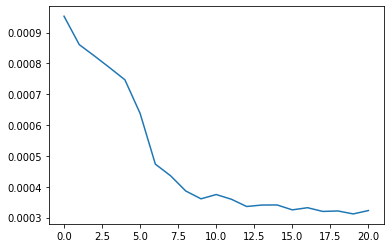

In [514]:
plt.plot(history.history['loss'])

In [515]:
prediction = model.predict(test_gen)
pred_train = model.predict(train_gen)

In [516]:
prediction.shape

(7718, 1)

In [517]:
rev_pred = scaler_col.inverse_transform(prediction)
rev_test = scaler_col.inverse_transform(y_test.reshape(-1,1))

rev_train_pred = scaler_col.inverse_transform(pred_train.reshape(-1,1))
rev_train = scaler_col.inverse_transform(y_train.reshape(-1,1))

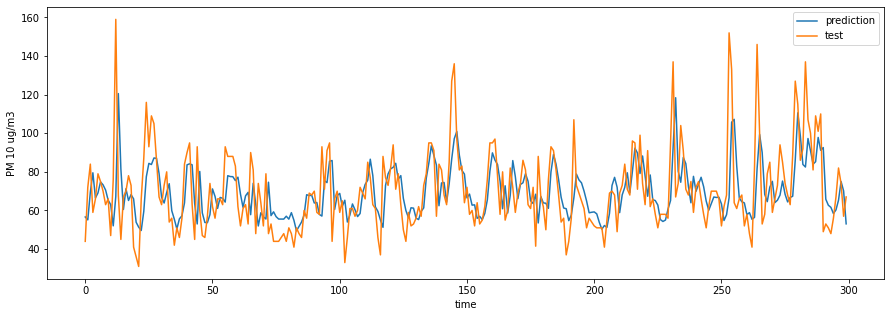

In [526]:
ns=300
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(rev_pred[:ns],label = 'prediction')
ax.plot(rev_test[win_length:][:ns], label = 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('PM 10 ug/m3')
plt.savefig('pm_10.png',bbox_inches='tight')
plt.show()

In [527]:
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mpe 
from scipy.stats import pearsonr as pearson

print(f'mse on test: {mse(rev_test[win_length:],rev_pred,squared=False)} \nmse on train: {mse(rev_train[win_length:],rev_train_pred,squared = False)}')


mse on test: 28.357760145897345 
mse on train: 26.95364703583145


In [528]:
mpe(rev_test[win_length:],rev_pred)

0.2332825675097854

In [529]:
print(f'correlation on test: {pearson(rev_test[win_length:].flatten(),rev_pred.flatten())[0]} \ncorrelation on train: {pearson(rev_train[win_length:].flatten(),rev_train_pred.flatten())[0]}')

correlation on test: 0.8098363982313271 
correlation on train: 0.8494162752263452


# tuning the parameters 

In [550]:
import keras_tuner as kt

def model_builder(hp):
    model = tf.keras.Sequential()

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    
    model.add(Conv1D(input_shape = (win_length,n_f),activation = 'tanh' ,filters  = hp_units , kernel_size = 3, strides = 1, padding='same'))
    model.add(layers.MaxPooling1D(4))

    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    
    model.add(LSTM(units = hp_units2,  activation='relu', return_sequences = True))
    model.add(Dropout(0.2))

    hp_units3 = hp.Int('units3', min_value=5, max_value=100, step=5)

    model.add(LSTM(units = hp_units3,  activation='relu', return_sequences = False))
    model.add(Dropout(0.2))
    
    hp_units4 = hp.Int('units4', min_value=5, max_value=100, step=5)
    model.add(Dense(units = hp_units4,  activation='relu')  )
    model.add(Dropout(0.2))

    model.add(Dense(1,  activation='linear')  )

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate) ,metrics=['mse'])


    return model

In [556]:
tuner = kt.Hyperband(model_builder,
                     objective='loss',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('D:/'),
                     project_name='LTSM-Conv')

INFO:tensorflow:Reloading Oracle from existing project D:\LTSM-Conv\oracle.json


In [557]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [558]:
tuner.search(train_gen, epochs=50, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""layer 1: {best_hps.get('units1')}\n layer 2: {best_hps.get('units2')} \n layer 3: {best_hps.get('units3')} \n layer 4: {best_hps.get('units4')} \n lr: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 54s]
loss: 0.0005115768290124834

Best loss So Far: 0.00031460903119295835
Total elapsed time: 00h 09m 54s
INFO:tensorflow:Oracle triggered exit
layer 1: 85
 layer 2: 50 
 layer 3: 10 
 layer 4: 40 
 lr: 0.001.



In [566]:
def model_fn(win_length,n_f):
    model = tf.keras.Sequential()
    model.add(Conv1D(input_shape = (win_length,n_f),activation = 'tanh' ,filters  = 85 , kernel_size = 3, strides = 1, padding='same'))
    model.add(layers.MaxPooling1D(4))
    
    model.add(LSTM(50,  activation='relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(10,  activation='relu', return_sequences = False))
    model.add(Dropout(0.2))
    

    model.add(Dense(40,  activation='relu')  )
    model.add(Dropout(0.2))

    model.add(Dense(1,  activation='linear')  )
    model.compile(loss = keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate = .001) )

    return model

In [567]:
model = model_fn(win_length,n_f)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 20, 85)            2635      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 85)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 50)             27200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)               

In [568]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
history = model.fit(train_gen, epochs = 50, validation_data = test_gen, shuffle = False,callbacks=[early_stopping],verbose=1)

Epoch 1/50
967/967 [==============================] - 6s 4ms/step - loss: 9.3826e-04 - val_loss: 8.8850e-04
Epoch 2/50
967/967 [==============================] - 4s 4ms/step - loss: 8.4610e-04 - val_loss: 8.6349e-04
Epoch 3/50
967/967 [==============================] - 4s 4ms/step - loss: 8.2319e-04 - val_loss: 8.0891e-04
Epoch 4/50
967/967 [==============================] - 4s 4ms/step - loss: 7.9299e-04 - val_loss: 7.8375e-04
Epoch 5/50
967/967 [==============================] - 4s 4ms/step - loss: 7.4373e-04 - val_loss: 7.1539e-04
Epoch 6/50
967/967 [==============================] - 4s 4ms/step - loss: 6.6843e-04 - val_loss: 5.6473e-04
Epoch 7/50
967/967 [==============================] - 4s 4ms/step - loss: 5.2010e-04 - val_loss: 4.4571e-04
Epoch 8/50
967/967 [==============================] - 4s 4ms/step - loss: 4.3788e-04 - val_loss: 3.9458e-04
Epoch 9/50
967/967 [==============================] - 4s 4ms/step - loss: 3.9473e-04 - val_loss: 3.9306e-04
Epoch 10/50
967/967 [=======

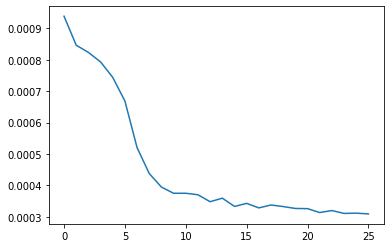

In [569]:
plt.plot(history.history['loss'])

In [570]:
prediction = model.predict(test_gen)
pred_train = model.predict(train_gen)

In [571]:
rev_pred = scaler_col.inverse_transform(prediction)
rev_test = scaler_col.inverse_transform(y_test.reshape(-1,1))

rev_train_pred = scaler_col.inverse_transform(pred_train.reshape(-1,1))
rev_train = scaler_col.inverse_transform(y_train.reshape(-1,1))

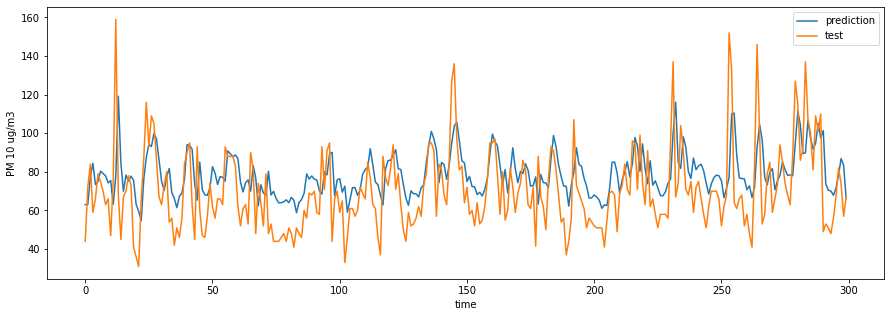

In [572]:
ns=300
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(rev_pred[:ns],label = 'prediction')
ax.plot(rev_test[win_length:][:ns], label = 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('PM 10 ug/m3')
#plt.savefig('pm_10.png',bbox_inches='tight')
plt.show()

In [573]:
print(f'mse on test: {mse(rev_test[win_length:],rev_pred,squared=False)} \nmse on train: {mse(rev_train[win_length:],rev_train_pred,squared = False)}')

mse on test: 27.53860809541109 
mse on train: 26.240632067402228


In [574]:
mpe(rev_test[win_length:],rev_pred)

0.303259136722459

# PM_2.5

In [12]:
df = pd.read_csv('pm_25.csv',parse_dates = True, index_col =0)
df.head()

,station,PM 2.5 ug/m3,tempC,windspeedKmph,winddirDegree,humidity,pressure,cloudcover,precipMM,uvIndex,DewPointC
2017-01-01 00:00:00,صدر.منطقه3,103.0,3,5,49,62,1020,10,0.0,1,-4
2017-01-01 01:00:00,صدر.منطقه3,88.0,3,4,47,64,1019,13,0.0,1,-3
2017-01-01 02:00:00,صدر.منطقه3,77.0,3,4,45,65,1019,16,0.0,1,-3
2017-01-01 03:00:00,صدر.منطقه3,68.0,3,3,43,67,1018,19,0.0,1,-3
2017-01-01 04:00:00,صدر.منطقه3,68.0,3,3,46,69,1018,23,0.0,1,-3


In [13]:
df.drop('station',axis = 1,inplace = True)

In [14]:
imputer = KNNImputer(n_neighbors = 2)
X = imputer.fit_transform(df)
df = pd.DataFrame(X,columns = df.columns,index = df.index)

In [15]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
Y = X[:,0]
scaler_col = MinMaxScaler()
col = scaler_col.fit_transform(df['PM 2.5 ug/m3'].to_numpy().reshape(-1,1))

In [16]:
print(f'X: {X.shape} , Y: {Y.shape}')

X: (38687, 10) , Y: (38687,)


In [17]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, shuffle = False)

In [18]:
win_length = 20
batch_size = 32 
n_f = X.shape[1]
train_gen = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate = 1, batch_size = batch_size)
test_gen = TimeseriesGenerator(x_test, y_test, length = win_length, sampling_rate = 1, batch_size = batch_size)

In [19]:
def model_fn(win_length,n_f):
    model = tf.keras.Sequential()
    model.add(Conv1D(input_shape = (win_length,n_f),activation = 'tanh' ,filters  = 64 , kernel_size = 3, strides = 1, padding='same'))
    model.add(layers.MaxPooling1D(4))
    #model.add(LSTM(32, input_shape = (win_length,n_f), activation='relu',return_sequences=True))
    #model.add(LSTM(32, input_shape = (win_length,n_f), activation='relu',return_sequences=True))
    
    #model.add(Dense(64,  activation='relu')  )
    #model.add(Dropout(0.2))
    
    model.add(LSTM(32,  activation='relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(32,  activation='relu', return_sequences = False))
    model.add(Dropout(0.2))
    

    model.add(Dense(32,  activation='relu')  )
    model.add(Dropout(0.2))

    model.add(Dense(1,  activation='linear')  )
    model.compile(loss = keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate = .001) )

    return model

In [20]:
model = model_fn(win_length,n_f)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 64)            1984      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 32)             12416     
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [21]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')
history = model.fit(train_gen, epochs = 50, validation_data = test_gen, shuffle = False,callbacks=[early_stopping],verbose=1)

Epoch 1/50
967/967 [==============================] - 5s 4ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 2/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 3/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/50
967/967 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0013

In [33]:
%%time
prediction = model.predict(test_gen)
pred_train = model.predict(train_gen)

Wall time: 1.16 s


In [23]:
rev_pred = scaler_col.inverse_transform(prediction)
rev_test = scaler_col.inverse_transform(y_test.reshape(-1,1))

rev_train_pred = scaler_col.inverse_transform(pred_train.reshape(-1,1))
rev_train = scaler_col.inverse_transform(y_train.reshape(-1,1))

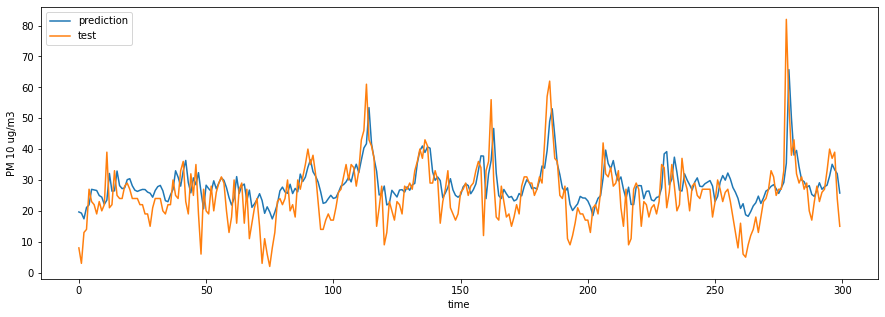

In [28]:
ns=300
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(rev_pred[:ns],label = 'prediction')
ax.plot(rev_test[win_length:][:ns], label = 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('PM 10 ug/m3')
plt.savefig('pm_25.png',bbox_inches='tight')
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mpe 
from scipy.stats import pearsonr as pearson

print(f'mse on test: {mse(rev_test[win_length:],rev_pred,squared=False)} \nmse on train: {mse(rev_train[win_length:],rev_train_pred,squared = False)}')
print(f'correlation on test: {pearson(rev_test[win_length:].flatten(),rev_pred.flatten())[0]} \ncorrelation on train: {pearson(rev_train[win_length:].flatten(),rev_train_pred.flatten())[0]}')

print(f'MPE on test: {mpe(rev_test[win_length:],rev_pred)}')

mse on test: 9.94039981842684 
mse on train: 10.866587917714163
correlation on test: 0.9279861120988102 
correlation on train: 0.8759836650464699
MPE on test: 0.3125739558415804
